## Yacine Mahdid May 30 2020
The goal of this notebook is to generate the visualization from the results gathered in the first phase. This step is separated from result generation as we don't need lots of computing power for visualization.

### Steps:
- [x] Double check that all the results are in the right format and can be unpickled
- [ ] Generate the statistics for the number of windows for each states
- [x] Generate Violin plot for the bootstrap confidence interval
- [x] Generate Feature importance plot
- [x] Generate the analysis for healthy
- [x] Generate the analysis for msk
- [x] Generate comparison of each participant type

In [1]:
import pickle
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

from ml_tools.classification import load_pickle

# Double checking that all the results are in the right format and can be unpickled
participant_type = "HEALTHY"
input_dir = f"/home/yacine/Documents/BIAPT/eeg_pain_result/{participant_type}/"
output_dir = f"/home/yacine/Documents/BIAPT/eeg_pain_result/{participant_type}/"

# Basic information
features_filename = input_dir + 'features_all.csv'

# Clf performance
acc_filename = input_dir + 'accuracies_result.pickle'
f1_filename = input_dir + 'f1s_result.pickle'

# Clf validation
best_params_filename = input_dir + 'best_params.pickle'
bootstrap_filename = input_dir + 'bootstrap.pickle'
permutation_filename = input_dir + 'permutation_test.pickle'

# Final Clf explanability information
clf_filename = input_dir + 'trained_gs.pickle'
features_weight_filename = input_dir + 'features.pickle'


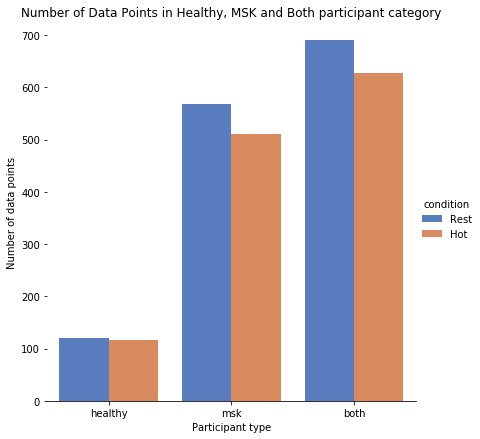

[121, 117, 569, 510, 690, 627]
Healthy Rest/Hot 1.0341880341880343
MSK Rest/Hot 1.115686274509804
Both Rest/Hot 1.1004784688995215


In [2]:
def get_window(df, participant_type):
    ''' helper to get the number of window for a participant type'''
    if participant_type != -1:
        df = df[df.type == participant_type]
    
    num_window_baseline = len(df[df.is_hot == 0].id)
    num_window_hot = len(df[df.is_hot == 1].id)
    
    return [num_window_baseline, num_window_hot]

# Original dataframe used to generate the result
df = pd.read_csv(features_filename)
fig_name = "/home/yacine/Documents/BIAPT/eeg_pain_result/windows_proportion.png"
data = {
    'participant_type': ['healthy', 'healthy', 'msk', 'msk', 'both', 'both'],
    'num_window': get_window(df, 1) + get_window(df, 0) + get_window(df, -1),
    'condition': ['Rest', 'Hot']*3
}


df = pd.DataFrame(data, columns = ['participant_type','num_window', 'condition'])

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="participant_type", y="num_window", hue="condition", data=df,height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("Number of data points")
g.set_xlabels("Participant type")
plt.title('Number of Data Points in Healthy, MSK and Both participant category')

fig = plt.gcf()
plt.show()
fig.set_size_inches((15, 11), forward=False)
fig.savefig(fig_name, dpi=500)

print(data['num_window'])
healthy_prop = data['num_window'][0]/data['num_window'][1]
msk_prop = data['num_window'][2]/data['num_window'][3]
both_prop = data['num_window'][4]/data['num_window'][5]

print("Healthy Rest/Hot", healthy_prop)
print("MSK Rest/Hot", msk_prop)
print("Both Rest/Hot", both_prop)

In [3]:
accuracies = load_pickle(acc_filename)
f1s = load_pickle(f1_filename)

{'SVC_kernel=linear_C= 1': 1, 'LOG_penality=l2_C=7.742636826811269': 1, 'LOG_penality=l2_C=1.0': 3, 'LOG_penality=l2_C=59.94842503189409': 1, 'LOG_penality=l2_C=2.7825594022071245': 1, 'LOG_penality=l2_C=1291.5496650148827': 2, 'SVC_kernel=linear_C= 10': 2, 'LOG_penality=l2_C=10000.0': 1}
(0.4892260832400825, 0.7451101107641356)


/home/yacine/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LinearSVC from version 0.23.0 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/yacine/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.0 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


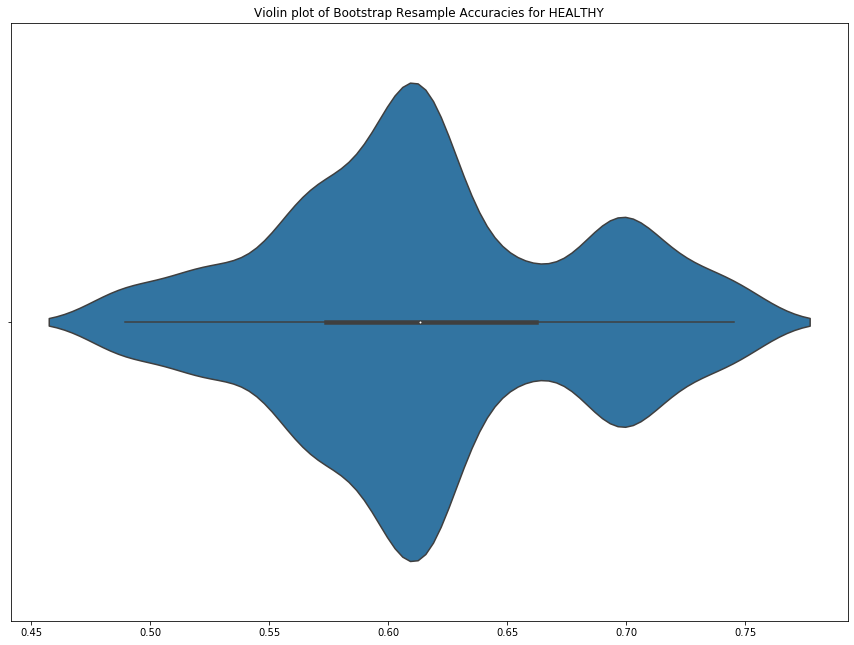

In [4]:
def find_best_model(best_params):
    models_occurence = {}
    for param in best_params:
        clf = param['clf']
        if isinstance(clf, LogisticRegression):
            key = f"LOG_penality={param['clf__penalty']}_C={param['clf__C']}"
        elif isinstance(clf, LinearSVC):
            key = f"SVC_kernel=linear_C= {param['clf__C']}"
        elif isinstance(clf, DecisionTreeClassifier):
            key = f"DEC_criterion{param['clf__criterion']}"
        
        if key not in models_occurence:
            models_occurence[key] = 1
        else:
            models_occurence[key] = models_occurence[key] + 1

    return models_occurence

# Will need to double check how I'm doing this I'm getting difficult to parse result
best_params = load_pickle(best_params_filename)
print(find_best_model(best_params))

# This is a dictionary with two key: distribution and interval
bootstrap = load_pickle(bootstrap_filename)
#bootstrap['distribution']
print(bootstrap['interval'])

fig_name = output_dir + 'bootstrap_resampling.png'
fig = plt.gcf()
ax = sns.violinplot(bootstrap['distribution'])
ax.set_title(f"Violin plot of Bootstrap Resample Accuracies for {participant_type}")
fig.set_size_inches((15, 11), forward=False)
fig.savefig(fig_name, dpi=500)

# This is the n run of the permutation testing
permutation = load_pickle(permutation_filename)

In [40]:
# Trained classifier (Where is this one coming from?)
clf = load_pickle(clf_filename)

/home/yacine/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.23.0 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/yacine/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.0 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/yacine/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.0 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/yacine/.local/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.0 when using version 0.23.1. This might lead to breaking code or inval

Size Name:  157
Size Weight:  157


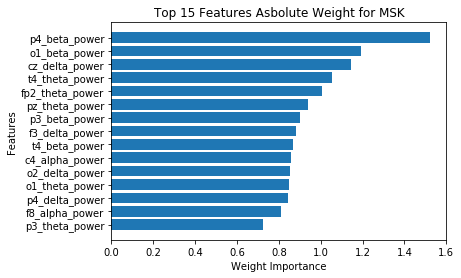

In [41]:
def f_importances(coef, names, fig_name, top=-1):
    '''Helper function to plot the feature importance'''
    imp = abs(coef)
    imp,names = zip(*sorted(zip(imp,names)))
    
    # Show all features
    if top == -1:
        top = len(names)
        
    limit = len(names) - top
    
    plt.barh(range(top), imp[limit:], align='center')
    plt.yticks(range(top), names[limit:])
    plt.title(f"Top {top} Features Asbolute Weight for {participant_type}")
    plt.xlabel("Weight Importance")
    plt.ylabel("Features")
        
    fig = plt.gcf()
    plt.show()
    fig.set_size_inches((15, 11), forward=False)
    fig.savefig(fig_name, dpi=500)
    
# This might be better as a dataframe
features_weight = load_pickle(features_weight_filename)
weight_importance_filename = output_dir + 'f_importance.png'
print("Size Name: ", len(features_weight['name']))
print("Size Weight: ", len(features_weight['weight']))

f_importances(features_weight['weight'], features_weight['name'],  weight_importance_filename, 15)

[1.3926155352705574, 0.7674161607863044, 0.5789020067430003]
[3.742939093808107, 0.2869886249118934, 0.36642508140113283]
[3.626767080651397, 0.30159141489444047, 0.10547576934815078]


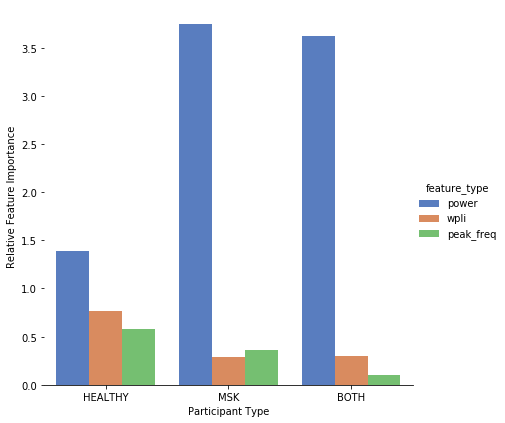

[0.9120436754537974, 0.7980000688478809, 1.2064515639400037, 1.145395955871433]
[1.0206550255597753, 1.1796892143284599, 0.8043299086508713, 1.0477819318331114]
[1.137912870516026, 1.1832206707013821, 0.8783754517142521, 0.8373684991188658]


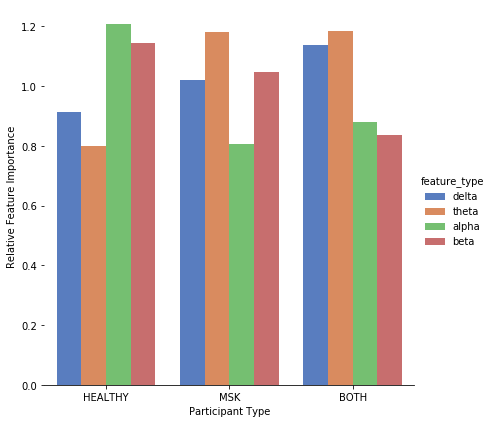

In [77]:
def relative_weight(weights, names, target):
    target_weights = []
    out_weights = []
    for weight, name in zip(weights, names):
        if target in name:
            target_weights.append(weight)
        else:
            out_weights.append(weight)
        
    return np.mean(target_weights) / np.mean(out_weights)

def generate_feature_importance(feature_type):

    participant_types = ['HEALTHY', 'MSK', 'BOTH']
    data = {
        'participant_type' : [],
        'feature_type' : [],
        'relative_weight' : [],    
    }

    for participant_type in participant_types:
        features_weight_filename = f"/home/yacine/Documents/BIAPT/eeg_pain_result/{participant_type}/features.pickle"
        features_weight = load_pickle(features_weight_filename)

        weights = abs(features_weight['weight'])
        names = features_weight['name']
        weight_per_class = [relative_weight(weights, names, type) for type in feature_type]
        print(weight_per_class)

        data['participant_type'] = data['participant_type'] + [participant_type]*len(weight_per_class)
        data['feature_type'] = data['feature_type'] + feature_type
        data['relative_weight'] = data['relative_weight'] + weight_per_class
    
    return data

def plot_feature_importance(fig_name, data):
    df = pd.DataFrame(data, columns = ['participant_type','feature_type', 'relative_weight'])

    # Draw a nested barplot to show survival for class and sex
    g = sns.catplot(x="participant_type", y="relative_weight", hue="feature_type", data=df,height=6, kind="bar", palette="muted")
    g.despine(left=True)
    g.set_ylabels("Relative Feature Importance")
    g.set_xlabels("Participant Type")

    fig = plt.gcf()
    plt.show()
    fig.set_size_inches((15, 11), forward=False)
    fig.savefig(fig_name, dpi=500)
    

# Feature Type
fig_name = "/home/yacine/Documents/BIAPT/eeg_pain_result/feature_type_comparison.png"
feature_type = ['power', 'wpli', 'peak_freq']
data = generate_feature_importance(feature_type)
plot_feature_importance(fig_name, data)

# Frequency Band
fig_name = "/home/yacine/Documents/BIAPT/eeg_pain_result/frequency_type_comparison.png"
feature_type = ['delta', 'theta', 'alpha', 'beta']
data = generate_feature_importance(feature_type)
plot_feature_importance(fig_name, data)

In [83]:
# Sum up the channel weight across modality
def channel_weights(weights, names, channel):
    channel_weight = 0
    for weight, name in zip(weights, names):
        if channel in name:
            channel_weight = channel_weight + weight
    return channel_weight

def generate_feature_importance(channel_names):

    participant_types = ['HEALTHY', 'MSK', 'BOTH']
    
    data = {
        'participant_type' : [],
        'channel_names' : [],
        'weight' : [],    
    }

    for participant_type in participant_types:
        features_weight_filename = f"/home/yacine/Documents/BIAPT/eeg_pain_result/{participant_type}/features.pickle"
        features_weight = load_pickle(features_weight_filename)

        weights = abs(features_weight['weight'])
        names = features_weight['name']
        
        weight_per_channel = [channel_weights(weights, names, channel) for channel in channel_names]

        data['participant_type'] = data['participant_type'] + [participant_type]*len(weight_per_channel)
        data['channel_names'] = data['channel_names'] + channel_names
        data['weight'] = data['weight'] + weight_per_channel
        
        df = pd.DataFrame(data, columns = ['participant_type','channel_names', 'weight'])
    
    return df

df_name = "/home/yacine/Documents/BIAPT/eeg_pain_result/channels_importance.csv"
channel_names = ['fp1','fp2','fz','f3','f4','f7','f8','cz','c3','c4','t3','t4','t5','t6','pz','p3','p4','o1','o2']
df = generate_feature_importance(channel_names)
df.to_csv(df_name)

['fp1_delta_power',
 'fp2_delta_power',
 'fz_delta_power',
 'f3_delta_power',
 'f4_delta_power',
 'f7_delta_power',
 'f8_delta_power',
 'cz_delta_power',
 'c3_delta_power',
 'c4_delta_power',
 't3_delta_power',
 't4_delta_power',
 't5_delta_power',
 't6_delta_power',
 'pz_delta_power',
 'p3_delta_power',
 'p4_delta_power',
 'o1_delta_power',
 'o2_delta_power',
 'peak_freq_delta',
 'fp1_delta_wpli',
 'fp2_delta_wpli',
 'fz_delta_wpli',
 'f3_delta_wpli',
 'f4_delta_wpli',
 'f7_delta_wpli',
 'f8_delta_wpli',
 'cz_delta_wpli',
 'c3_delta_wpli',
 'c4_delta_wpli',
 't3_delta_wpli',
 't4_delta_wpli',
 't5_delta_wpli',
 't6_delta_wpli',
 'pz_delta_wpli',
 'p3_delta_wpli',
 'p4_delta_wpli',
 'o1_delta_wpli',
 'o2_delta_wpli',
 'fp1_theta_power',
 'fp2_theta_power',
 'fz_theta_power',
 'f3_theta_power',
 'f4_theta_power',
 'f7_theta_power',
 'f8_theta_power',
 'cz_theta_power',
 'c3_theta_power',
 'c4_theta_power',
 't3_theta_power',
 't4_theta_power',
 't5_theta_power',
 't6_theta_power',
 'pz_

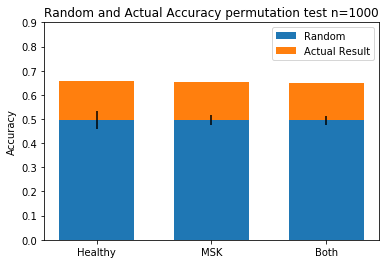

Random:
(0.49582510874793484, 0.49562976435748374, 0.49415278163579934)
Accuracies
(0.6591539750507142, 0.6530189004161145, 0.6497767995902545)
Actual Improvement
(0.16332886630277932, 0.1573891360586308, 0.15562401795445513)
Healthy, MSK, Both


In [35]:
fig_name = "/home/yacine/Documents/BIAPT/eeg_pain_result/chance_improvement.png"


b_perms = load_pickle("/home/yacine/Documents/BIAPT/eeg_pain_result/BOTH/permutation_test.pickle")
b_acc = load_pickle("/home/yacine/Documents/BIAPT/eeg_pain_result/BOTH/accuracies_result.pickle")

h_perms = load_pickle("/home/yacine/Documents/BIAPT/eeg_pain_result/HEALTHY/permutation_test.pickle")
h_acc = load_pickle("/home/yacine/Documents/BIAPT/eeg_pain_result/HEALTHY/accuracies_result.pickle")

m_perms = load_pickle("/home/yacine/Documents/BIAPT/eeg_pain_result/MSK/permutation_test.pickle")
m_acc = load_pickle("/home/yacine/Documents/BIAPT/eeg_pain_result/MSK/accuracies_result.pickle")

# Next up we will do a comparison plot of each permutation tests iteration
N = 3
random_acc = (np.mean(h_perms), np.mean(m_perms), np.mean(b_perms))
actual_acc = (np.mean(h_acc) - np.mean(h_perms), np.mean(m_acc) - np.mean(m_perms), np.mean(b_acc) - np.mean(b_perms))
y_err = [np.std(h_perms), np.std(m_perms), np.std(b_perms)]
ind = np.arange(N)    # the x locations for the groups
width = 0.65       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, random_acc, width, yerr=y_err)
p2 = plt.bar(ind, actual_acc, width, bottom=random_acc)


plt.ylabel('Accuracy')
plt.title('Random and Actual Accuracy permutation test n=1000')
plt.xticks(ind, ('Healthy', 'MSK', 'Both'))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend((p1[0], p2[0]), ('Random', 'Actual Result'))

fig = plt.gcf()
plt.show()
fig.set_size_inches((15, 11), forward=False)
fig.savefig(fig_name, dpi=500)


print("Random:")
print(random_acc)
print("Accuracies")
print((np.mean(h_acc), np.mean(m_acc),np.mean(b_acc)))
print("Actual Improvement")
print(actual_acc)
print("Healthy, MSK, Both")

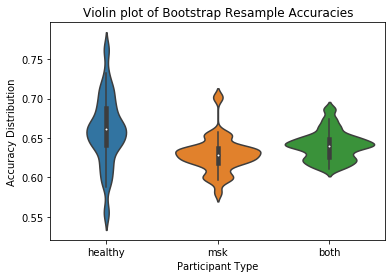

Bootstrap Interval at n=1000 and p < 0.05
(0.5555587272628761, 0.7619241613106378)
(0.5809622846522915, 0.7016064799906095)
(0.610640506456953, 0.6864339650979646)
Healthy, MSK, Both


In [33]:
# Finally we will compare all three violin plot together
fig_name = "/home/yacine/Documents/BIAPT/eeg_pain_result/bootstrap_comparison.png"


b_bootstrap = load_pickle("/home/yacine/Documents/BIAPT/eeg_pain_result/BOTH/bootstrap.pickle")

h_bootstrap = load_pickle("/home/yacine/Documents/BIAPT/eeg_pain_result/HEALTHY/bootstrap.pickle")

m_bootstrap = load_pickle("/home/yacine/Documents/BIAPT/eeg_pain_result/MSK/bootstrap.pickle")

# I need to first take the data and put it in a dataframe
h_label = ['healthy' for x in h_bootstrap['distribution']]
m_label = ['msk' for x in m_bootstrap['distribution']]
b_label = ['both' for x in b_bootstrap['distribution']]

data = {'Accuracy Distribution':  h_bootstrap['distribution'] + m_bootstrap['distribution'] + b_bootstrap['distribution'],
        'Participant Type': h_label + m_label + b_label,
        }

df = pd.DataFrame (data, columns = ['Accuracy Distribution','Participant Type'])
ax = sns.violinplot(data=df, x='Participant Type', y='Accuracy Distribution')
ax.set_title("Violin plot of Bootstrap Resample Accuracies")

fig = plt.gcf()
plt.show()
fig.set_size_inches((15, 11), forward=False)
fig.savefig(fig_name, dpi=500)

print("Bootstrap Interval at n=1000 and p < 0.05")
print(h_bootstrap['interval'])
print(m_bootstrap['interval'])
print(b_bootstrap['interval'])
print("Healthy, MSK, Both")